# Performing differential expression analysis on PTM data w multiple conditions

Here, we will take phospho data processed with Spectronaut and 
 * perform phosphosite inference and perform differential expression analysis on the phospho sites
 * take proteome data and normalize the differential expression results

## Defining input files
As with the standard differential expression analysis, we need:

* an input file from a proteomics search engine. We currently only support Spectronaut, DIA-NN will come soon
* a sample mapping file that maps each sample to a condition (e.g.  sample 'brain_replicate_1' is mapped to condition 'brain'). In the GUI, there is some functionality to help create such a file
* (optional) a results directory can be defined on where to save the data
* (optional) a list where we specify, which conditions we compare

Simple specifications on how to export the Spectronaut file for PTM analysis can be found in the [README](https://github.com/MannLabs/alphaquant/blob/master/README.md#preparing-input-files).

In [1]:
PHOSPHO_FILE = "./data/phospho/phospho_subset.tsv"
SAMPLEMAP_PHOSPHO = "./data/phospho/samplemap_phospho.tsv"
RESULTS_DIR_PHOSPHO = "./data/phospho/results_phospho_multicond"

PROTEOME_FILE = "./data/phospho/proteome_subset.tsv"
SAMPLEMAP_PROTEOME = "./data/phospho/samplemap_proteome.tsv"
RESULTS_DIR_PROTEOME = "./data/phospho/results_proteome_multicond"



Let's quickly check what the phospho tables look like:

In [2]:
import pandas as pd

phospho_df = pd.read_csv(PHOSPHO_FILE, sep="\t")
samplemap_phospho_df = pd.read_csv(SAMPLEMAP_PHOSPHO, sep="\t")
display(phospho_df.head())
#check the ptm columns
display([x for x in phospho_df.columns if "EG.PTM" in x])
#show the samplemap
display(samplemap_phospho_df.head())



/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_59080/3128896955.py:3: DtypeWarning: Columns (8,31,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  phospho_df = pd.read_csv(PHOSPHO_FILE, sep="\t")


,PG.ProteinGroups,R.FileName,R.Label,PG.Genes,PG.Organisms,PG.UniProtIds,PG.Quantity,PEP.NrOfMissedCleavages,PEP.PeptidePosition,PEP.StrippedSequence,...,F.FrgLossType,F.Rank,F.ExcludedFromQuantification,F.PeakArea,F.PeakHeight,F.HasChannelInterference,F.InterferenceScore,F.Log10SignalToNoise,F.Noise,F.PossibleInterference
0,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,0,False,10883.600586,102643.0,False,0.000000,2.375846,NaN,False
1,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,NH3,1,True,449.196930,3710.0,False,0.225726,1.297532,NaN,False
2,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,2,False,1254.857544,10727.0,False,0.225726,1.854387,NaN,False
3,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,3,False,964.486145,7393.0,False,0.140666,1.670164,NaN,False
4,Q14676,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,MDC1,Homo sapiens,Q14676,6121.10498,0,784,AIPGDQHPESPVHTEPMGIQGR,...,noloss,4,False,790.209412,7567.0,False,0.197118,1.339848,NaN,False


['EG.PTMPositions [Phospho (STY)]',
 'EG.PTMProbabilities [Phospho (STY)]',
 'EG.PTMSites [Phospho (STY)]',
 'EG.PTMLocalizationProbabilities',
 'EG.PTMAssayCandidateScore',
 'EG.PTMAssayProbability',
 'EG.PTMPositions [Oxidation (M)]',
 'EG.PTMPositions [Carbamidomethyl (C)]',
 'EG.PTMPositions [Acetyl (Protein N-term)]',
 'EG.PTMProbabilities [Oxidation (M)]',
 'EG.PTMProbabilities [Carbamidomethyl (C)]',
 'EG.PTMProbabilities [Acetyl (Protein N-term)]',
 'EG.PTMSites [Oxidation (M)]',
 'EG.PTMSites [Carbamidomethyl (C)]',
 'EG.PTMSites [Acetyl (Protein N-term)]']

,sample,condition
0,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,egf_treated
1,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,egf_treated
2,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,egf_treated
3,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,untreated
4,202106022_TIMS03_EVO03_PaSk_SA_HeLa_Phospho_10...,untreated


importantly, here are site probability columns for different types of variable modifications including phospho

## Running AlphaQuant on phospho

Calling AlphaQuant on ptm data, we additionally have to specify the modification we are interested in. In our case it is `[Phospho (STY)]` as listed in the headers above

In [4]:
import alphaquant.run_pipeline as aq_pipeline
import warnings
warnings.filterwarnings('always')


aq_pipeline.run_pipeline(input_file=PHOSPHO_FILE, samplemap_file=SAMPLEMAP_PHOSPHO, results_dir=RESULTS_DIR_PHOSPHO, 
                         perform_ptm_mapping=True,modification_type="[Phospho (STY)]",organism="human", multicond_median_analysis=True)

filtered PTM peptides from 3219 to 2845


/Users/constantin/workspace/alphaquant/alphaquant/ptm/ptmsite_mapping.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.loc[:,"REFPROT"] = get_idmap_column(input_df[headers_dict.get("proteins")],swissprot_ids)
/Users/constantin/workspace/alphaquant/alphaquant/ptm/ptmsite_mapping.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df.loc[:,"IonID"] = input_df[label_column] + input_df[fg_id_column]


assigned 60 of 2845 0.0210896309314587
assigned 639 of 2845 0.22460456942003515
assigned 867 of 2845 0.3047451669595782
assigned 903 of 2845 0.31739894551845343
assigned 1221 of 2845 0.42917398945518453
assigned 1349 of 2845 0.47416520210896307
assigned 2417 of 2845 0.8495606326889279
assigned 2477 of 2845 0.8706502636203867
assigned 2566 of 2845 0.901933216168717
assigned 2612 of 2845 0.9181019332161687
assigned 2693 of 2845 0.9465729349736379
assigned 2774 of 2845 0.9750439367311072
assigned 2832 of 2845 0.9954305799648506
adding ptm info to spectronaut file
100000 lines read
using input type spectronaut_ptm_fragion_isotopes


/Users/constantin/workspace/alphaquant/alphaquant/diffquant/diffutils.py:242: ResourceWarning: unclosed file <_io.TextIOWrapper name='./data/phospho/results_phospho_multicond/aq_parameters.yaml' mode='r' encoding='UTF-8'>
  return load_config(params_file)


start processeing condpair ('egf_treated', 'median_reference')
normalized within conditions
median 0.0, mode -0.03856005789704242
using median for shift
shift comparison by -0.0
normalized between conditions
t_ion2nonan_sw 0.015172243118286133
t_intensity_selection 0.1759800910949707
t_ion2nonan_sw 0.0195920467376709
t_intensity_selection 0.2216320037841797
checked 0 of 6814 ions
checked 2000 of 6814 ions
checked 4000 of 6814 ions
checked 6000 of 6814 ions
checked 0 of 150 prots
checked 100 of 150 prots

condition pair ('egf_treated', 'median_reference') finished!

start processeing condpair ('untreated', 'median_reference')
normalized within conditions
median 0.0, mode -0.008400963794364058
using median for shift
shift comparison by -0.0
normalized between conditions
t_ion2nonan_sw 0.013314008712768555
t_intensity_selection 0.15385127067565918
t_ion2nonan_sw 0.020689964294433594
t_intensity_selection 0.22607898712158203
checked 0 of 5857 ions
checked 2000 of 5857 ions
checked 4000 of 

/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/si

### Inspecting and visualizing phospho results

Let's check out the results table located in the results directory:

In [5]:
results_file_phospho = RESULTS_DIR_PHOSPHO + "/egf_treated_VS_median_reference.results.tsv"

In [6]:
import pandas as pd
df_phospho = pd.read_csv(results_file_phospho, sep="\t")
display(df_phospho.head())

,condition_pair,protein,p_value,log2fc,number_of_ions,quality_score,total_intensity,num_peptides,PEP.StrippedSequence,fdr
0,egf_treated_VS_median_reference,TEX264_Q9Y6I9_['S244'],1.167437e-07,0.317861,39,0.049740,24272.837047,1,ETSAATLSPGASSR,0.000001
1,egf_treated_VS_median_reference,CBL_P22681_[nan],8.073734e-01,0.004877,239,0.445618,156899.398611,7,ELTNRHSLPFSLPSQMEPRPDVPR,0.976585
2,egf_treated_VS_median_reference,USP8_P40818_['Y717'],8.989635e-01,0.004877,20,0.041253,5515.514221,1,SYSSPDITQAIQEEEK,0.976585
3,egf_treated_VS_median_reference,"EGFR_P00533_[nan, 'S1042']",4.206701e-01,0.088237,25,0.051170,7918.116168,1,TPLLSSLSATSNNSTVACIDR,0.751197
4,egf_treated_VS_median_reference,NBR1_Q14596_['T658'],8.262813e-01,0.031121,51,0.109593,30185.141646,1,SLTLDAAPDHNPPCR,0.976585


#### Volcano plot

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'5 up, 1 down of 150'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

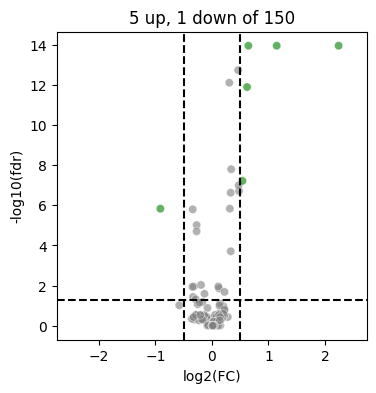

In [7]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

aq_plotting_pairwise.volcano_plot(df_phospho)

#### Normalization check

In [8]:
normalized_df = pd.read_csv(RESULTS_DIR_PHOSPHO + "/egf_treated_VS_median_reference.results.tsv", sep='\t')
samplemap_df = pd.read_csv(SAMPLEMAP_PHOSPHO, sep='\t')

## Run AlphaQuant on proteome data

In [9]:
import alphaquant.run_pipeline as aq_pipeline

aq_pipeline.run_pipeline(input_file=PROTEOME_FILE, samplemap_file=SAMPLEMAP_PROTEOME, results_dir=RESULTS_DIR_PROTEOME, multicond_median_analysis=True)

using input type spectronaut_fragion_isotopes


/Users/constantin/workspace/alphaquant/alphaquant/diffquant/diffutils.py:242: ResourceWarning: unclosed file <_io.TextIOWrapper name='./data/phospho/results_proteome_multicond/aq_parameters.yaml' mode='r' encoding='UTF-8'>
  return load_config(params_file)


start processeing condpair ('egf_treated', 'median_reference')
normalized within conditions
median 0.05573198069801144, mode -0.036092576452580294
using mode for shift
shift comparison by 0.036092576452580294
normalized between conditions
t_ion2nonan_sw 0.011682987213134766
t_intensity_selection 0.1775209903717041
t_ion2nonan_sw 0.012737035751342773
t_intensity_selection 0.19144415855407715
checked 0 of 4577 ions
checked 2000 of 4577 ions
checked 4000 of 4577 ions
checked 0 of 30 prots

condition pair ('egf_treated', 'median_reference') finished!

start processeing condpair ('untreated', 'median_reference')
normalized within conditions
median -0.3160028820820244, mode -0.336441253877095
using median for shift
shift comparison by 0.3160028820820244
normalized between conditions
t_ion2nonan_sw 0.012259721755981445
t_intensity_selection 0.16484308242797852
t_ion2nonan_sw 0.01170802116394043
t_intensity_selection 0.1790940761566162
checked 0 of 4567 ions
checked 2000 of 4567 ions
checked 4

/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/si

### Volcano plot

In [10]:
results_file_proteome = RESULTS_DIR_PROTEOME + "/egf_treated_VS_median_reference.results.tsv"

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'0 up, 0 down of 30'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

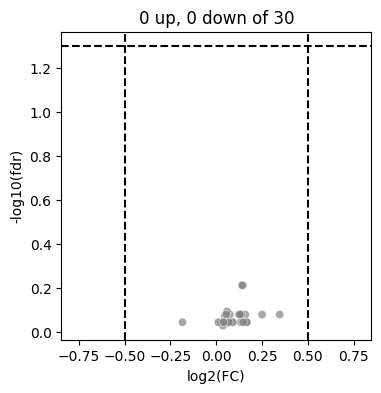

In [11]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

df_proteome = pd.read_csv(results_file_proteome, sep="\t")
aq_plotting_pairwise.volcano_plot(df_proteome)

There is very little regulation on the protein level.

## Combining phospho and proteome data by proteome-normalization

The following command writes out the proteome normed files into a new results directory with the ending "_protnormed"

In [12]:
import alphaquant.ptm.protein_ptm_normalization as aq_ptm_normalization

aq_ptm_normalization.PTMResultsNormalizer(results_dir_ptm=RESULTS_DIR_PHOSPHO, 
                                          results_dir_proteome=RESULTS_DIR_PROTEOME, organism="human")

wrote proteome normalized tables to: ./data/phospho/results_phospho_multicond_protnormed


### Volcano plot

In [13]:
results_file_protnormed = f"{RESULTS_DIR_PHOSPHO}_protnormed/egf_treated_VS_median_reference.results.tsv"

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'4 up, 2 down of 143'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

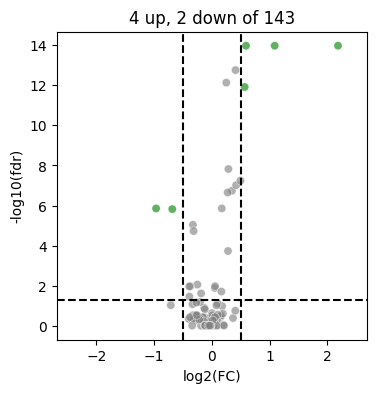

In [14]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

df_protnormed = pd.read_csv(results_file_protnormed, sep="\t")
aq_plotting_pairwise.volcano_plot(df_protnormed)

As expected, there is little qualitative change to this plot, because the protein regulation is low. Let's investigate this a bit futher:

Text(0, 0.5, 'log2fc_proteome')

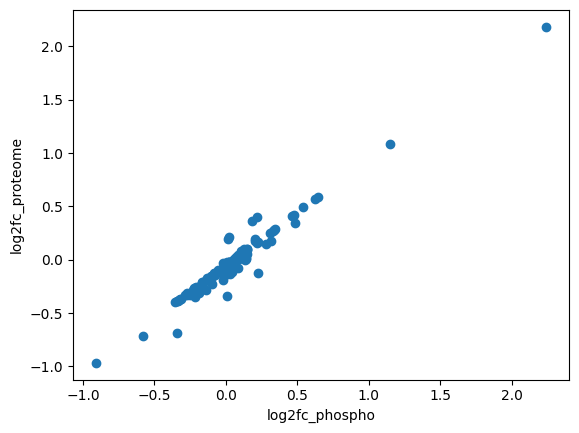

In [15]:
import matplotlib.pyplot as plt
merged_df = df_phospho.merge(df_protnormed, on="protein", how="inner", suffixes=("_phospho", "_proteome"))
plt.scatter(merged_df["log2fc_phospho"], merged_df["log2fc_proteome"])
plt.xlabel("log2fc_phospho")
plt.ylabel("log2fc_proteome")

Indeed we see few changes per phospo site, but some difference due to some protein fold changes, as expected.